# Answering Business Questions using SQL

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

In [2]:
def run_query(query):
    with sql.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)

In [3]:
def run_command(query):
    with sql.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(query)

In [4]:
def show_tables():
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(query)

In [5]:
run_command('DROP VIEW IF EXISTS country_base')
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting New Albums to Purchase

In [6]:
query_purchase_albums = '''
WITH usa_sold AS
   (
    SELECT invl.* FROM invoice_line invl
    INNER JOIN invoice inv ON inv.customer_id = c.customer_id
    INNER JOIN customer c on inv.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    ge.name genre,
    COUNT(us.invoice_line_id) tracks_sold,
    ROUND(CAST(COUNT(us.invoice_line_id) AS FLOAT)*100 / (
        SELECT COUNT(*) from usa_sold
    ),2) || "%" percentage_sold
FROM usa_sold us
INNER JOIN track tr ON tr.track_id = us.track_id
INNER JOIN genre ge ON ge.genre_id = tr.genre_id
GROUP BY 1
ORDER BY 2 DESC;
'''

In [7]:
purchase_albums = run_query(query_purchase_albums)
purchase_albums

,genre,tracks_sold,percentage_sold
0,Rock,345185,55.39%
1,Metal,81089,13.01%
2,Alternative & Punk,64452,10.34%
3,Latin,21877,3.51%
4,R&B/Soul,20829,3.34%
5,Blues,16244,2.61%
6,Jazz,15851,2.54%
7,Alternative,15327,2.46%
8,Easy Listening,9694,1.56%
9,Pop,8253,1.32%


In [8]:
purchase_albums.set_index("genre", inplace=True, drop=True)

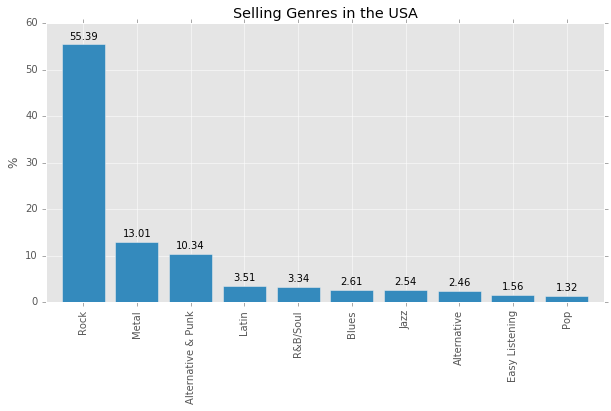

In [9]:
width = 0.8

tick_positions = np.arange(1,purchase_albums['percentage_sold'][:10].size+1)
print_data = list(purchase_albums['percentage_sold'] \
.str.replace('%', '').astype(float).iloc[:10])

fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.bar(tick_positions+0.5,
      print_data,
      width,
      align='center')

for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_title('Selling Genres in the USA')
ax.set_xticks(tick_positions+0.5)
ax.set_xticklabels(purchase_albums.index.values, rotation =90)
ax.set_ylabel('%')
plt.margins(x=0.03)

plt.show()

# Analyzing Employee Sales Performance

In [10]:
query_employee_sales = '''
WITH customer_support_table AS
    (
     SELECT
         inv.customer_id,
         cs.support_rep_id,
         SUM(inv.total) total
     FROM invoice inv
     INNER JOIN customer cs ON inv.customer_id = cs.customer_id
     GROUP BY 1,2
    )

SELECT
    em.first_name || " " || em.last_name employee,
    SUM(cst.total) total_sales,
    em.hire_date
FROM customer_support_table cst
INNER JOIN employee em ON em.employee_id = cst.support_rep_id
GROUP BY 1;
'''

In [11]:
employee_sales = run_query(query_employee_sales)
employee_sales

,employee,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


In [12]:
employee_sales.set_index("employee", inplace=True, drop=True)
employee_sales.sort_values("total_sales", inplace=True)

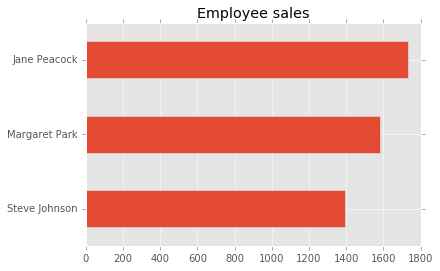

In [13]:
employee_sales.plot.barh(
    legend=False,
    title='Employee sales'
    )
plt.ylabel('')
plt.show()

# Analyzing Sales by Country

In [14]:
view_table = """
CREATE VIEW country_base AS
    SELECT
       CASE
           WHEN (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = cs.country
                ) = 1 THEN "Other"
           ELSE cs.country
       END AS country,
       inv.customer_id,
       inv.invoice_id,
       inv.total
    FROM invoice inv
    INNER JOIN customer cs ON cs.customer_id = inv.customer_id
"""

In [15]:
run_command(view_table)

In [16]:
quary_country_sales = '''
SELECT
    country,
    customers,
    total_sales,
    average_order,
    average_customer_value
FROM
    (
    SELECT
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(total) total_sales,
        ROUND(SUM(total) / COUNT(DISTINCT customer_id),3) average_customer_value,
        ROUND(SUM(total) / COUNT(DISTINCT invoice_id),3) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_base
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

In [17]:
country_sales = run_query(quary_country_sales)
country_sales

,country,customers,total_sales,average_order,average_customer_value
0,USA,13,1040.49,7.943,80.038
1,Canada,8,535.59,7.047,66.949
2,Brazil,5,427.68,7.011,85.536
3,France,5,389.07,7.781,77.814
4,Germany,4,334.62,8.161,83.655
5,Czech Republic,2,273.24,9.108,136.620
6,United Kingdom,3,245.52,8.769,81.840
7,Portugal,2,185.13,6.384,92.565
8,India,2,183.15,8.721,91.575
9,Other,15,1094.94,7.449,72.996


# Visualizing Sales by Country

In [18]:
country_sales_visual = country_sales.set_index("country")
del country_sales_visual.index.name


In [19]:
country_sales_visual['color'] = ['#ff0000', '#FFA500', '#98FB98',
                                '#F0E68C', '#808000', '#20B2AA',
                                '#7B68EE', '#EE82EE', '#A0522D', '#008B8B']

<function matplotlib.pyplot.show>

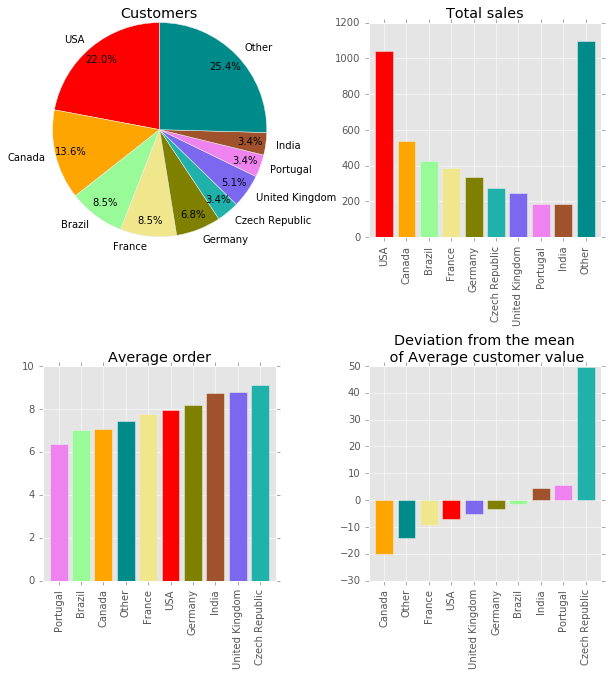

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0,0].pie(country_sales_visual['customers'],
            labels=country_sales_visual.index,
            autopct='%1.1f%%',
            startangle=90,
            pctdistance = 0.85,
            colors = country_sales_visual['color'])
ax[0,0].axis('equal')
ax[0,0].set_title('Customers')

ax[0,1].bar(tick_positions+0.5,
      country_sales_visual['total_sales'],
      width,
      align='center',
      color = country_sales_visual['color'])
ax[0,1].set_title('Total sales')
ax[0,1].set_xticks(tick_positions+0.5)
ax[0,1].set_xticklabels(country_sales_visual.index.values, rotation =90)
ax[0,1].margins(x=0.03)

ax[1,0].bar(tick_positions+0.5,
      country_sales_visual['average_order'].sort_values(),
      width,
      align='center',
      color = country_sales_visual.sort_values('average_order')['color'])
ax[1,0].set_title('Average order')
ax[1,0].set_xticks(tick_positions+0.5)
ax[1,0].set_xticklabels(country_sales_visual['average_order'].sort_values().\
                        index.values,
                        rotation =90)
ax[1,0].margins(x=0.03)

average_customer_value_mean =country_sales_visual\
                                ['average_customer_value'].mean()
country_sales_visual['average_customer_value'] = \
    country_sales_visual['average_customer_value']- \
    average_customer_value_mean
ax[1,1].bar(tick_positions+0.5,
      country_sales_visual['average_customer_value'].sort_values(),
      width,
      align='center',
      color = country_sales_visual.sort_values('average_customer_value')['color'])
ax[1,1].set_title('Deviation from the mean\n of Average customer value')
ax[1,1].set_xticks(tick_positions+0.5)
ax[1,1].set_xticklabels(country_sales_visual['average_customer_value'].sort_values().\
                        index.values,
                        rotation =90)
ax[1,1].margins(x=0.03)


fig.subplots_adjust(hspace=.6, wspace=.4)
plt.show

# Albums vs Individual Tracks

In [21]:
query_purchase = '''
WITH invoice_album AS
    (
     SELECT
         invl.invoice_id invoice_id,
         tr.album_id album_id
     FROM invoice_line invl
     INNER JOIN track tr ON tr.track_id = invl.track_id
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    ROUND(CAST(COUNT(invoice_id) AS FLOAT)*100 / (
                                    SELECT COUNT(*) FROM invoice
                                      ),2) || "%"  percent
FROM
    (
    SELECT
        ia.invoice_id,
        CASE
            WHEN
                 (
                  SELECT tr2.track_id FROM track tr2
                  WHERE tr2.album_id = ia.album_id

                  EXCEPT 

                  SELECT invl2.track_id FROM invoice_line invl2
                  WHERE invl2.invoice_id = ia.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT invl2.track_id FROM invoice_line invl2
                  WHERE invl2.invoice_id = ia.invoice_id

                  EXCEPT 

                  SELECT tr2.track_id FROM track tr2
                  WHERE tr2.album_id = ia.album_id
                  
                 ) IS NULL
             THEN "Yes"
             ELSE "No"
         END AS "album_purchase"
     FROM invoice_album ia
    )
GROUP BY album_purchase;
'''

In [22]:
run_query(query_purchase)

,album_purchase,number_of_invoices,percent
0,No,500,81.43%
1,Yes,114,18.57%
